# Plots and analysis
This notebook contains plots and other code to explore guesses of the players of the game.

In [1]:
import math
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt


#### NB: Don't forget to run all the scripts prior to this step.

In [2]:
# Load all inputs
df_raw = pd.read_csv('../data/answers.csv',error_bad_lines=False)

#check
df_raw.shape

(23, 4)

In [3]:
df_raw.head()

,Timestamp,Current URL,Player,Guess
0,2021/01/14 11:20:26 PM GMT+1,URL11,Player1,Player2
1,2021/01/14 11:21:25 PM GMT+1,URL11,Player2,Player10
2,2021/01/14 11:21:45 PM GMT+1,URL11,Player7,Player1
3,2021/01/14 11:22:01 PM GMT+1,URL11,Player8,Player11
4,2021/01/14 11:22:21 PM GMT+1,URL11,Player6,Player1


In [4]:
df_raw.groupby('Current URL').count()

,Timestamp,Player,Guess
Current URL,,,
URL10,11,11,11
URL11,11,11,11
URL6,1,1,1


In [5]:
#df_raw.shape
# which urls
urls = df_raw['Current URL'].unique()
print(urls.tolist())


['URL11', 'URL10', 'URL6']


# Graphs

In [6]:
# first dumb graph, ignores weights
G = nx.from_pandas_edgelist(df_raw, 'Player', 'Guess',)

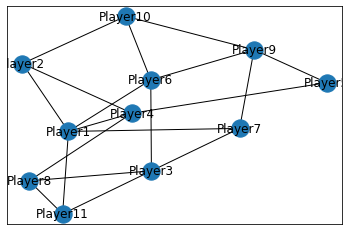

In [7]:
# Visualize, TODO: add per URL
nx.draw_networkx(G)

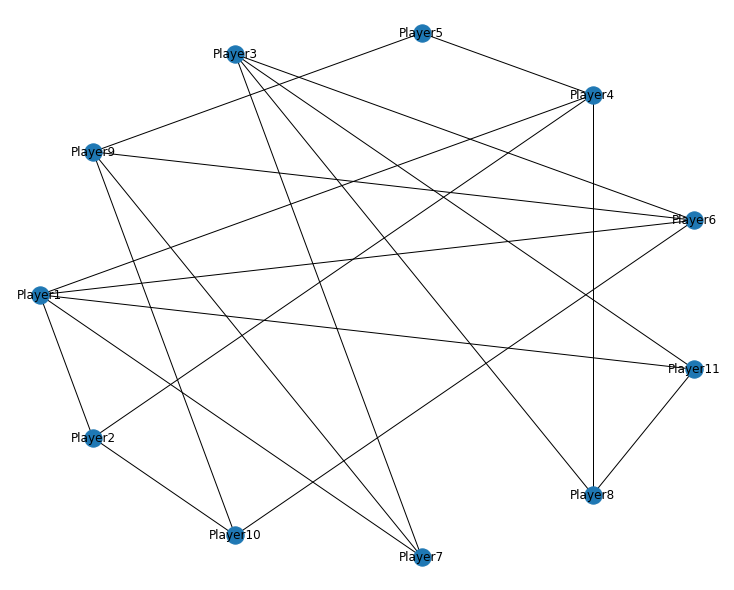

In [8]:
# a bit more space
plt.figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

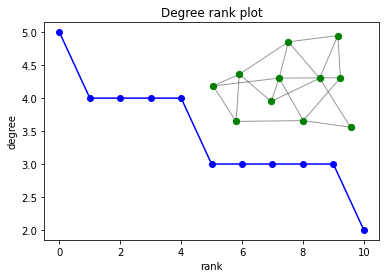

In [9]:
# another look via degree sequences
# source: from networkx gallery

degree_dist = sorted([vote for player, vote in G.degree()], reverse=True)
dmax = max(degree_dist)

plt.plot(degree_dist, "b-", marker="o")
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
# TOFIX: directed graph?
plt.axes([0.5, 0.5, 0.35, 0.35])
g_cc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=False)[0])
pos = nx.spring_layout(g_cc)
plt.axis("off")
nx.draw_networkx_nodes(g_cc, pos, node_size=40, node_color="green")
nx.draw_networkx_edges(g_cc, pos, arrowstyle="->", arrowsize=10, alpha=0.4)

# Statistics
### Most popular and least votes

In [10]:
def create_leaderboard(df,col_name, tab_header):
    leaderboard = df[col_name].value_counts(ascending=True)
    s = pd.Series(leaderboard, name=tab_header)
    df2 = s.to_frame().sort_values(tab_header, ascending=False)
    return df2

In [11]:
# total votes for each player
total_votes = create_leaderboard(df_raw,'Guess','votes')
total_votes

,votes
Player3,4
Player4,4
Player1,3
Player6,3
Player2,2
Player9,2
Player11,1
Player7,1
Player10,1
Player8,1


In [12]:
# total number of votes per link
votes_links = create_leaderboard(df_raw,'Current URL','votes')
votes_links

,votes
URL10,11
URL11,11
URL6,1


In [13]:
# stats of guesses per URL
df_raw.groupby(by=['Current URL', 'Guess'])['Guess'].count()

Current URL  Guess   
URL10        Player1     1
             Player2     1
             Player3     2
             Player4     4
             Player6     3
URL11        Player1     2
             Player10    1
             Player11    1
             Player2     1
             Player3     1
             Player5     1
             Player7     1
             Player8     1
             Player9     2
URL6         Player3     1
Name: Guess, dtype: int64

In [14]:
# looking at the guesses per URL slice
df_url_guess=df_raw.loc[:,['Current URL','Guess']] #only guesses per URL
df_url_guess.head()

,Current URL,Guess
0,URL11,Player2
1,URL11,Player10
2,URL11,Player1
3,URL11,Player11
4,URL11,Player1


In [15]:
# code from https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
# create a leaderboard
# this is total stats, TODO: add per URL

leaderboard = {}
for x in G.nodes:
    leaderboard[x] = ??#len(G[x])
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)
df2

SyntaxError: invalid syntax (<ipython-input-15-566dcd6b4709>, line 7)

In [ ]:
#df_votes.plot.bar(x='Current URL')
#df_raw.columns
#df_raw.columns[3]


In [ ]:
#sumValues = df_url_guess.len().value_counts()
#print(sumValues)